In [1]:
import pandas as pd
import numpy as np
import re

In [78]:
features = pd.read_excel('Healthcare_dataset.xlsx', engine='openpyxl', sheet_name='Feature Description')
data = pd.read_excel('Healthcare_dataset.xlsx', engine='openpyxl', sheet_name='Dataset', na_values=['Unknown', 'Other/Unknown'])

In [3]:
idn = [i for i in data.columns if re.match("^idn*", i.lower()) != None]
features.loc[features["Variable"] == 'IDN Indicator']

,Bucket,Variable,Variable Description
7,NaN,IDN Indicator,Flag indicating patients mapped to IDN


In [4]:
# Counting rows with NA
na_count = data.shape[0] - data.dropna().shape[0]
percent_na = na_count / data.shape[0] * 100
print("Percent of rows with NAs = ", percent_na, "%")

Percent of rows with NAs =  69.50934579439252 %


In [5]:
#Extract rows with NA values only
nan_df = data[data.isna().any(axis=1)]
#Count frequency of persistency flag
persist_na = nan_df['Persistency_Flag'].value_counts()['Persistent']
persist_tot = data['Persistency_Flag'].value_counts()['Persistent']

print('How many persistent flags will be removed by deletion method: ', persist_na / persist_tot * 100, '%')

How many persistent flags will be removed by deletion method:  64.70131885182312 %


In [6]:
#Map values to numbers
columns_map = {}
columns_decode = {}
for col in data.columns:
    if str(data[col].dtype) == 'object':  #If it's a categorical variable
        val_map = {}
        val_decode = {}
        mapped_value = 0
        for idx, val in enumerate(data[col].unique()): 
            not_na = True
            if type(val) == float:
                not_na = (np.isnan(val) != True)
            if  not_na == True: #If the value is not NaN add it to the mapping
                val_map[val] = mapped_value 
                val_decode[mapped_value] = val
                mapped_value += 1
            columns_map[col] = val_map
            columns_decode[col] = val_decode
            
print(columns_map['Ethnicity'])

{'Not Hispanic': 0, 'Hispanic': 1}


# OLD Imputation

# NEW Imputation

In [7]:
#dealing with missing data
from sklearn.impute import KNNImputer

df = data.copy()
#Using Mapping to encode data
for col in df.columns:
    if str(df[col].dtype) == 'object':
        df[col] = df[col].map(columns_map[col])
   
df_filled = df.copy()
imputer= KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df_filled)
df_filled = pd.DataFrame(df_filled, columns=df.columns).apply(round)
df_filled.isna().any().any()

False

# Outlier detection

# Descriptive Analysis


In [8]:
#Reverse mapping for visual analysis(decode)
df_eda = df_filled.copy()
for col in df_eda.columns:
    if col in columns_decode.keys():
        df_eda[col] = df_eda[col].map(columns_decode[col])
#Filter data variables related to comorbidity
df_eda = df_eda.filter(regex='^Comorb*|^[A-a]dherent*|^[P-p]ersistency')
print(f'Investigating Comorbidity and Adherence accounts for {df_eda.shape[1]} variables out of 67')

Investigating Comorbidity and Adherence accounts for 16 variables out of 67


In [9]:
#Descriptive analysis
pd.concat([df_eda.describe(), 
           pd.DataFrame({'percent': df_eda.describe().loc['freq'] * 100 / len(df_eda)}).transpose()])

,Persistency_Flag,Adherent_Flag,Comorb_Encounter_For_Screening_For_Malignant_Neoplasms,Comorb_Encounter_For_Immunization,"Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx",Comorb_Vitamin_D_Deficiency,Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified,Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx,Comorb_Long_Term_Current_Drug_Therapy,Comorb_Dorsalgia,Comorb_Personal_History_Of_Other_Diseases_And_Conditions,Comorb_Other_Disorders_Of_Bone_Density_And_Structure,Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias,Comorb_Osteoporosis_without_current_pathological_fracture,Comorb_Personal_history_of_malignant_neoplasm,Comorb_Gastro_esophageal_reflux_disease
count,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,Non-Persistent,Adherent,N,N,N,N,N,N,N,N,N,N,Y,N,N,N
freq,2135,3251,1891,1911,2072,2331,2425,2633,2607,2645,2747,2906,1765,2507,2775,2794
percent,62.353972,94.94743,55.227804,55.811916,60.514019,68.078271,70.823598,76.898364,76.139019,77.248832,80.227804,84.871495,51.547897,73.218458,81.045561,81.600467


In [10]:
#Renaming columns to shorter names with initials
import string
table = str.maketrans('', '', string.ascii_lowercase)
new_names = [i.translate(table).rstrip('_') for i in df_eda.columns]
new_names_encode = dict(zip(df_eda.columns, new_names))
new_names_decode = dict(zip(new_names, df_eda.columns))
df_eda = df_eda.rename(columns=new_names_encode)

# Observations from the plot below

1. Observations related to comorbidity do have an impact on Count of persistent flags

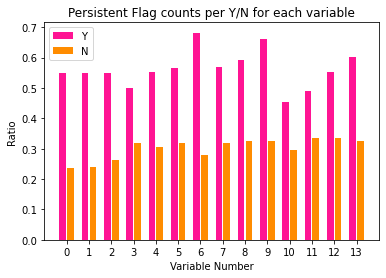

In [11]:
#Plotting counts of persistent and non persistent flags for "Y" labeled comorb
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()

Y_persist_height=[]
N_persist_height=[]
#Calculate Counts of persistent flags for each variable
for col_name, col_val in df_eda.loc[:, 'C_E_F_S_F_M_N':].iteritems():
    #Persistent flag count is scaled by the count of Yes flags.
    Y_persist_height.append(pd.crosstab(index=df_eda['P_F'], columns=col_val).loc['Persistent', 'Y'] / col_val.value_counts()['Y'])
    #Persistent flag count is scaled by the count of No flags.
    N_persist_height.append(pd.crosstab(index=df_eda['P_F'], columns=col_val).loc['Persistent', 'N'] / col_val.value_counts()['N']) 

x = np.arange(len(df_eda.columns)-2)
ax1.bar(x=x-0.35/2, height=Y_persist_height, width=0.3, label='Y', color='deeppink') 
ax1.bar(x=x+0.35/2, height=N_persist_height, width=0.3, label='N', color='darkorange')

ax1.set_title('Persistent Flag counts per Y/N for each variable')
ax1.set_xticks(x)
ax1.set_ylabel('Ratio')
ax1.set_xlabel('Variable Number')
plt.legend(loc='best')

In [12]:
print('Variables with higher Persistent counts when they have values "Yes":\n')
for col in [col_val for col_idx, col_val in enumerate(df_eda.columns[2:]) if Y_persist_height[col_idx] > N_persist_height[col_idx]]:
    print(new_names_decode[col])
    
print('\nVariables with higher Persistent counts when they have values "No":\n')    
for col in [col_val for col_idx, col_val in enumerate(df_eda.columns[2:]) if Y_persist_height[col_idx] < N_persist_height[col_idx]]:
    print(new_names_decode[col])

Variables with higher Persistent counts when they have values "Yes":

Comorb_Encounter_For_Screening_For_Malignant_Neoplasms
Comorb_Encounter_For_Immunization
Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx
Comorb_Vitamin_D_Deficiency
Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified
Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx
Comorb_Long_Term_Current_Drug_Therapy
Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias
Comorb_Personal_History_Of_Other_Diseases_And_Conditions
Comorb_Other_Disorders_Of_Bone_Density_And_Structure
Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias
Comorb_Osteoporosis_without_current_pathological_fracture
Comorb_Personal_history_of_malignant_neoplasm
Comorb_Gastro_esophageal_reflux_disease

Variables with higher Persistent counts when they have values "No":



In [13]:
#Performing Chi-Square, test of independence
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def independence_test(table):
    # interpret test-statistic
    stat, p, dof, expected = chi2_contingency(table)
    # interpret p-value
    alpha = 0.05
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
for col_name, col_val in df_eda.loc[:, 'C_E_F_S_F_M_N':].iteritems():
    table = pd.crosstab(index=df_eda['P_F'], columns=col_val)
    print('Testing Dependency of Persistency on ', new_names_decode[col_name])
    independence_test(table)
    print('')

Testing Dependency of Persistency on  Comorb_Encounter_For_Screening_For_Malignant_Neoplasms
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Encounter_For_Immunization
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Vitamin_D_Deficiency
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Long_Term_Current_Drug_Therapy
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Disorders_of_lipoprotein_metabolism_and_other_lipidemias
Dependent (reject H0)

Testing Dependency of Persistency on  Comorb_Personal_History_Of_Other_Diseases_And_Conditions
Dependent (rej

Text(0, 0.5, 'Ratio')

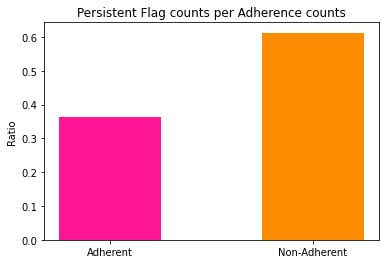

In [14]:
#Plotting Persistency flags against adherence
fig2, ax2 = plt.subplots()

adherent_persist_height= pd.crosstab(index=df_eda['P_F'], columns=df_eda['A_F']).loc['Persistent', 'Adherent'] / df_eda['A_F'].value_counts()['Adherent']
non_adherent_persist_height = pd.crosstab(index=df_eda['P_F'], columns=df_eda['A_F']).loc['Persistent', 'Non-Adherent'] / df_eda['A_F'].value_counts()['Non-Adherent']

x = np.array([1, 2])
ax2.bar(x=x[0], height=adherent_persist_height, width=0.5, color='deeppink') 
ax2.bar(x=x[1], height=non_adherent_persist_height, width=0.5, color='darkorange')

ax2.set_title('Persistent Flag counts per Adherence counts')
ax2.set_xticks(x)
ax2.set_xticklabels(['Adherent', 'Non-Adherent'])
ax2.set_ylabel('Ratio')

In [15]:
table = pd.crosstab(index=df_eda['P_F'], columns=df_eda['A_F'])
print('Testing Dependency of Persistency on Adherence')
independence_test(table)

Testing Dependency of Persistency on Adherence
Dependent (reject H0)


# Machine Learning Model Random Forest

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = df_filled.loc[:, df_filled.columns.difference(['Ptid', 'Persistency_Flag'])] #Design Matrix
y = df_filled['Persistency_Flag'] #Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8035019455252919


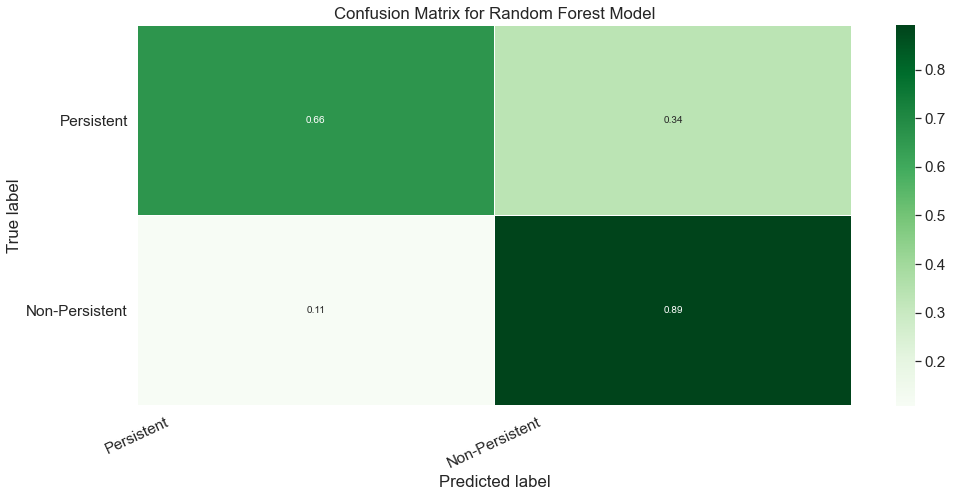

In [17]:
import seaborn as sns
#Confusion Matrix
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = [columns_decode['Persistency_Flag'][0], columns_decode['Persistency_Flag'][1]]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [18]:
# View the classification report for test data and predictions
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.66      0.72       399
         1.0       0.81      0.89      0.85       629

    accuracy                           0.80      1028
   macro avg       0.80      0.78      0.79      1028
weighted avg       0.80      0.80      0.80      1028



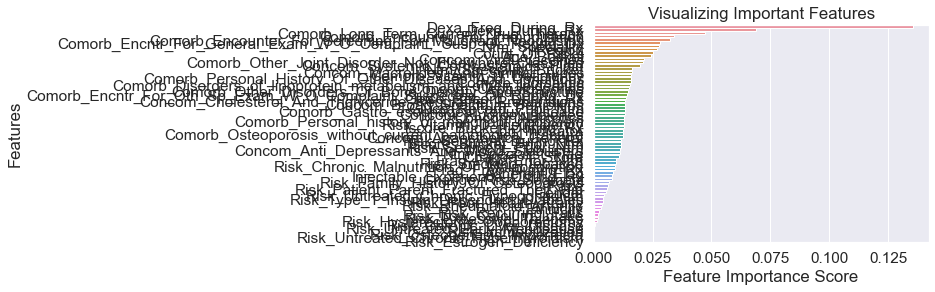

In [19]:
#Find most important features to the model
import seaborn as sns
feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [156]:
#Creating a YAML file as a template for Week 13
import json
template = df_filled.copy()
#Decoding values back to strings
for col in template.columns:
    if col in columns_decode.keys():
        template[col] = template[col].map(columns_decode[col])
    if str(template[col].dtype) in ['int64', 'float64']:
        template = template.astype({col: str(data[col].dtype)})
        
template = template.loc[:, template.columns.difference(['Persistency_Flag', 'Ptid'])]
#Writting schema to a Json file
template = pd.DataFrame({'Columns': template.dtypes.index, 'Dtype': template.dtypes.values})
myDict = {'Columns': list(template['Columns']), 'Dtype': list(map(str,list(template['Dtype'])))}
with open('template.json', 'w')as file:
    json.dump(myDict, file)

In [157]:
#Test validation
"""
Load json template, and store it in a dictionary.  
1- Check that all columns are present
2- Iterate through all the columns of the uploaded file and check each column w
your template dictionary.
"""
def validate_cols():
    """
    Function args
    -------------
    data_cols: df.columns() # A pandas.series
    config_cols: a list of column names from the configuration file
    """
    # Validate that columns match in both lists.
    if len(user_data.columns) == len(myTemplate) and (user_data.columns.sort_values() == myTemplate.sort_index().index).all():
        #Validate Dtype in each column
        for col in user_data.columns:
            if str(user_data[col].dtype) != myTemplate.loc[col, :].item():
                print(f"Expected {myTemplate.loc[col, :].item()} Dtype for {col}")
                print(f"Got {str(user_data[col].dtype)} instead.")
                return 
        print("Columns validation was successful")
        return
    else:
        print("Columns validation has failed")
        missing_in_json = list(set(user_data.columns).difference(list(myTemplate.index)))
        print('The following columns are not needed: ', missing_in_json)
        missing_in_data = list(set(list(myTemplate.index)).difference(user_data.columns))
        print('The following columns were not in your data: ', missing_in_data)
        return 

user_data = data.iloc[:, 2:].copy()
with open('template.json', 'r') as file:
    myTemplate = json.load(file)
myTemplate = pd.DataFrame(myTemplate)
myTemplate.set_index('Columns', inplace=True)
#Validate that all columns are present
validate_cols()
    

Columns validation was successful


# Important Terminology
## IDN 

Stands for **"Integrated Delivery Methods".**<br>
Think Mayo Clinic, basically it's an organization or a project, that involves more than one aspect of the health care business to ensure efficiency; e.g. health care, health insurance, clinics..etc, all in one. 

## HCP

Stands for **Health care provider**.<br>
All paid and unpaid persons serving in healthcare settings who have the potential for direct or indirect exposure to patients or infectious materials. Think Nurses, Physicians...etc.

## NTM

Stands for **Nontuberculous Mycobacteria** Infections. These are basically pathogens, think **COVID-19**.

### Relevant info

NTM are opportunistic pathogens placing some groups at **increased risk**, including those with underlying lung disease or depressed immune systems.<br>
NTM are **environmental organisms** that can be found in soil, dust, and water including natural water sources and municipal water sources.

## Rx

A medical prescription. The symbol "Rx" is usually said to stand for the Latin word "recipe" meaning **"to take."**<br>
**rxdate:** My guess, it is the date up to which the Rx is valid for.

**T-score:** Standard deviation from median under a T-distribution.

## Multiple Risk Factors

## Dexa Scan

It's a bone density scan. Results are compared to the average adult of same age using T-score.<br>
Used to asses body fat loss, as NTM causes loss of appetite and weight loss.

## Fragility Fracture

**WHO:** "Equivalent to a fall from a standing height or less".

## Comorbidity

The simultaneous presence of two or more diseases or medical conditions in a patient.

## Concomitant drug

Concomitant drugs are two or more drugs used or given at or almost at the same time (one after the other, on the same day, etc.).

# What to Expect: Using Data Analytics

From [Improving patient adherence through data-driven insights](https://www.mckinsey.com/industries/pharmaceuticals-and-medical-products/our-insights/improving-patient-adherence-through-data-driven-insights)

There are three principle measures of adherence:

* **Persistence**. How long patients take a drug before either switching to a new drug or stopping treatment entirely. 
* **Compliance**. How closely patients follow the prescribed treatment plan. This is measured by how many persistent patients fill their prescribed doses on schedule, based on the approved product label. 
* **Adherence**. Combined view of compliance and persistence, measured by the share of all patients, who fill their prescribed doses on schedule, based on the approved product label.<br><br>

* Adherence varies from one disease to the other. *(What other diseases was the patient suffering from? In dataset)*
* Low adherence is typical to chronic diseases.*(May expect low adherence from data)*
* Wide variations of persistence levels medication type. *(How was the medicine administered?)*
* Brand of drug (its effectiveness) is a pivoting factor. 

> These findings highlight the importance of identifying specific drivers of adherence for each individual medication or brand—indicating that it is important to understand the specifics of each medication or brand beyond just understanding the broad factors related to the disease category.

## Factors that influence adherence

<img src="https://www.mckinsey.com/~/media/McKinsey/Industries/Pharmaceuticals%20and%20Medical%20Products/Our%20Insights/Improving%20patient%20adherence%20through%20data%20driven%20insights/SVGZ-Improving-patient-adherence-Ex4.svgz" width=500><br>
<br>

**Important:**  

> Adherence may also be affected by factors linked to the healthcare system, such as the expertise, experience, and **quality of the physicians** and the structure of their practices. Across several different diseases, we found that patient adherence varied greatly by the physicians who treated them.

Dataset categorizes the physicians !<br>


**Important:**<br>
> In addition, the study showed that **comorbidities—conditions** that accompany a disease—tend to negatively correlate with adherence.

**Important:**
> The sheer number of medications a patient is taking can also be an important factor

**Important:**

> Recurring trends across diseases show that a patient’s level of involvement in the community and family-related factors are significant influencers.

# Week 8

## Dealing with outliers and NAs: Thought process

[Guide link](https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/#)

1. Is the missing data completely random ? Then use deletion; otherwise deletion might cause bias in the model.
2. Imputing (Probably using mode value because we have categorical variables)
3. Use Prediction models (Train the model with a part of the dataset with no missing values.), e.g. Logistic regression..etc
4. KNN Imputation.

[KNN Imputing in Python.](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)